In [1]:
import os  
import pandas            as pd
import numpy             as np 
import matplotlib.pyplot as plt
import seaborn           as sbn 


# AIM : see how change the combustion properties at different $P$ and $T$ for a reaction $O_2 + H_2 $

In [2]:
# setting up the interval of study
# reactants
O2 = np.linspace(0.025,0.975,100)
H2 = 1 - O2
# initial conditions
T  = np.linspace(200,1000,200)
P  = np.linspace(1,100,200)

### COMB() class:
####  get_data()
####  problem_generator()

In [3]:
# determining a class where storing the data 
class COMB:
    '''
    COMBUSTION results
    '''
    def __init__(self):
        self.P    = 0.0
        self.T    = 0.0
        self.of   = 0.0
        self.m    = 0.0
        self.cp   = 0.0
        self.H    = 0.0
        self.H2   = 0.0
        self.O    = 0.0
        self.O2   = 0.0
        self.O3   = 0.0
        self.OH   = 0.0
        self.H2O  = 0.0
        self.H2OL = 0.0
    
    def get_data(self,target):
        '''
        Reading data from the result of the NASA_CEA simulation
        '''
        with open(target, 'r') as file: 
            file.readlines(1)
            DATA = file.readlines(1)
            data = np.empty(0)
            # read only the 2nd line 
            for line in DATA:
                # reading each word in the line 
                for value in line.split():
                    data = np.concatenate((data, value), axis=None)
            
        # allocating data
        self.of   = float(data[0])
        self.P    = float(data[1])
        self.T    = float(data[2])
        self.m    = float(data[3])
        self.cp   = float(data[4]) 
        self.H    = float(data[5])
        self.H2   = float(data[6])
        self.O    = float(data[7])
        self.O2   = float(data[8])
        self.O3   = float(data[9])
        self.OH   = float(data[10])
        self.H2O  = float(data[11])
        self.H2OL = float(data[12])
   
    def problem_generation(self,T,P,FUEL,OX,target):
        '''
        This subroutine generates the ***.inp file to be analyzed by NASA_CEA
        The problem is a combustion problem. It's given in input:
            T      -- temperatue of each reactant
            P      -- pressure of the combustion chamber
            FUEL   -- total weight of fuel
            OX     -- total weight of oxidant
            target -- file name
        '''

        with open(target, 'w') as file: 
            file.write('problem   case=case_01 \n')
            text = '    hp   p,bar=' + str(P) + ',  t,k=' + str(T) + '\n'
            file.write(text)
            file.write('react \n')
            text = '    fuel=H2 wt=' + str(FUEL) + ',  t,k=' + str(T) + '\n'
            file.write(text)
            text = '    oxid=O2 wt=' + str(OX) +   ',  t,k=' + str(T) + '\n'  
            file.write(text)  
            file.write('output  transport short \n')
            file.write('    plot o/f p t m cp H H2 O O2 O3 OH H2O H2O(L)\n')
            file.write('end \n')  
        

# functions

In [4]:
def print_list(CC):
    '''
    This function gets the data from the COMB list and stores
    into the arrays:
        t  -- temperature array
        p  -- pressure array
        of -- O/F array
        m  -- molar mass array
        cp -- CP array
    '''
    # getting data from object list
    t    = np.zeros(len(CC))
    of   = np.zeros(len(CC))
    p    = np.zeros(len(CC))
    m    = np.zeros(len(CC))
    cp   = np.zeros(len(CC))
    H    = np.zeros(len(CC))
    H2   = np.zeros(len(CC))
    O    = np.zeros(len(CC))
    O2   = np.zeros(len(CC))
    O3   = np.zeros(len(CC))
    OH   = np.zeros(len(CC))
    H2O  = np.zeros(len(CC))
    H2OL = np.zeros(len(CC))

    # getting system status values
    # getting temperature
    for ii in range(0,len(CC)):
        t[ii] = CC[ii].T
    # getting of
    for ii in range(0,len(CC)):
        of[ii] = CC[ii].of
    # getting pressure
    for ii in range(0,len(CC)):
        p[ii] = CC[ii].P
    # getting average molecular mass
    for ii in range(0,len(CC)):
        m[ii] = CC[ii].m
    # getting cp
    for ii in range(0,len(CC)):
        cp[ii] = CC[ii].cp
   
    # getting species
    #getting H 
    for ii in range(0,len(CC)):
        H[ii] = CC[ii].H
    #getting H2
    for ii in range(0,len(CC)):
        H2[ii] = CC[ii].H
    #getting O
    for ii in range(0,len(CC)):
        O[ii] = CC[ii].O
    #getting O2 
    for ii in range(0,len(CC)):
        O2[ii] = CC[ii].O2
    #getting O3
    for ii in range(0,len(CC)):
        O3[ii] = CC[ii].O3
    #getting OH
    for ii in range(0,len(CC)):
        OH[ii] = CC[ii].OH
    #getting H2O 
    for ii in range(0,len(CC)):
        H2O[ii] = CC[ii].H2O
    #getting H2OL 
    for ii in range(0,len(CC)):
        H2OL[ii] = CC[ii].H2OL

    return t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL 

# Study of variation of properties varying the $ T $

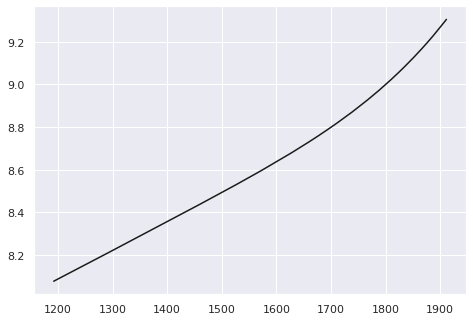

In [5]:
CC_T = np.array([COMB() for ii in range(0,len(T))])

for ii,temperature in enumerate(T):
    pressure = 1
    CC_T[ii].problem_generation(temperature,pressure,1,1,'case_01.inp') 
    os.system('bash ./CEA_case')
    CC_T[ii].get_data('case_01.plt')
    # erasing last element of the array --> points out it's null element
    if ii == len(T)-1:
        CC_T = CC_T[0:len(CC_T)-1]

# getting data from object list
t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_T)

# plotting data
sbn.set_theme()
fig = plt.figure()
ax  = fig.add_axes([0,0,1,1])
ax.plot(t,cp,'k')
plt.show()


# Study of variation of  properties varying the $P$

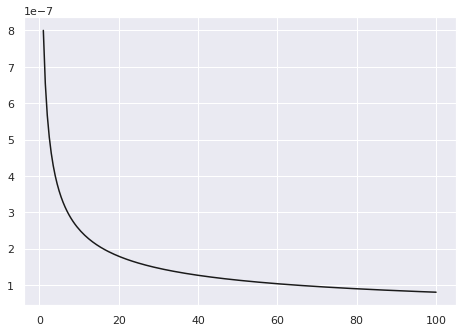

In [6]:
CC_P = np.array([COMB()])

for ii,pressure in enumerate(P):
    temperature = 300
    CC_P[ii].problem_generation(temperature,pressure,1,1,'case_01.inp') 
    os.system('bash ./CEA_case')
    CC_P[ii].get_data('case_01.plt')
    CC_P = np.append(CC_P, COMB())
    # erasing last element of the array --> points out it's null element
    if ii == len(P)-1:
        CC_P = CC_P[0:len(CC_P)-1]

# getting data from object list
t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_P)

# plotting data
sbn.set_theme()
fig1 = plt.figure()
ax   = fig1.add_axes([0,0,1,1])
ax.plot(p,H,'k')
plt.show()



# Study of variation of properties varying the $[H_2]$ and $[O_2]$

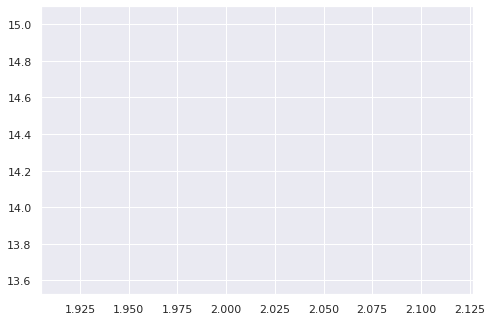

In [7]:
CC_C = [COMB()]

for ii,h2 in enumerate(H2):
    temperature = 300
    pressure    = 1
    CC_C[ii].problem_generation(temperature,pressure,h2,O2[ii],'case_01.inp') 
    os.system('bash ./CEA_case')
    CC_C[ii].get_data('case_01.plt')
    CC_C = np.append(CC_C, COMB())
    # erasing last element of the array --> points out it's null element
    if ii == len(H2)-1:
        CC_C = CC_C[0:len(CC_C)-1]

# getting data from object list
t, p, of, m, cp, H, H2, O, O2, O3, OH, H2O, H2OL = print_list(CC_C)

# plotting data
sbn.set_theme()
fig1 = plt.figure()
ax   = fig1.add_axes([0,0,1,1])
ax.plot(m,cp,'k')
plt.show()

# PLOT OF THE RESULTS

In [8]:
# concentration plotting 
%matplotlib inline 

# enabling seaborn package 
#sbn.set_theme()

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(CC_C[:].of,CC_C[:].T)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'of'